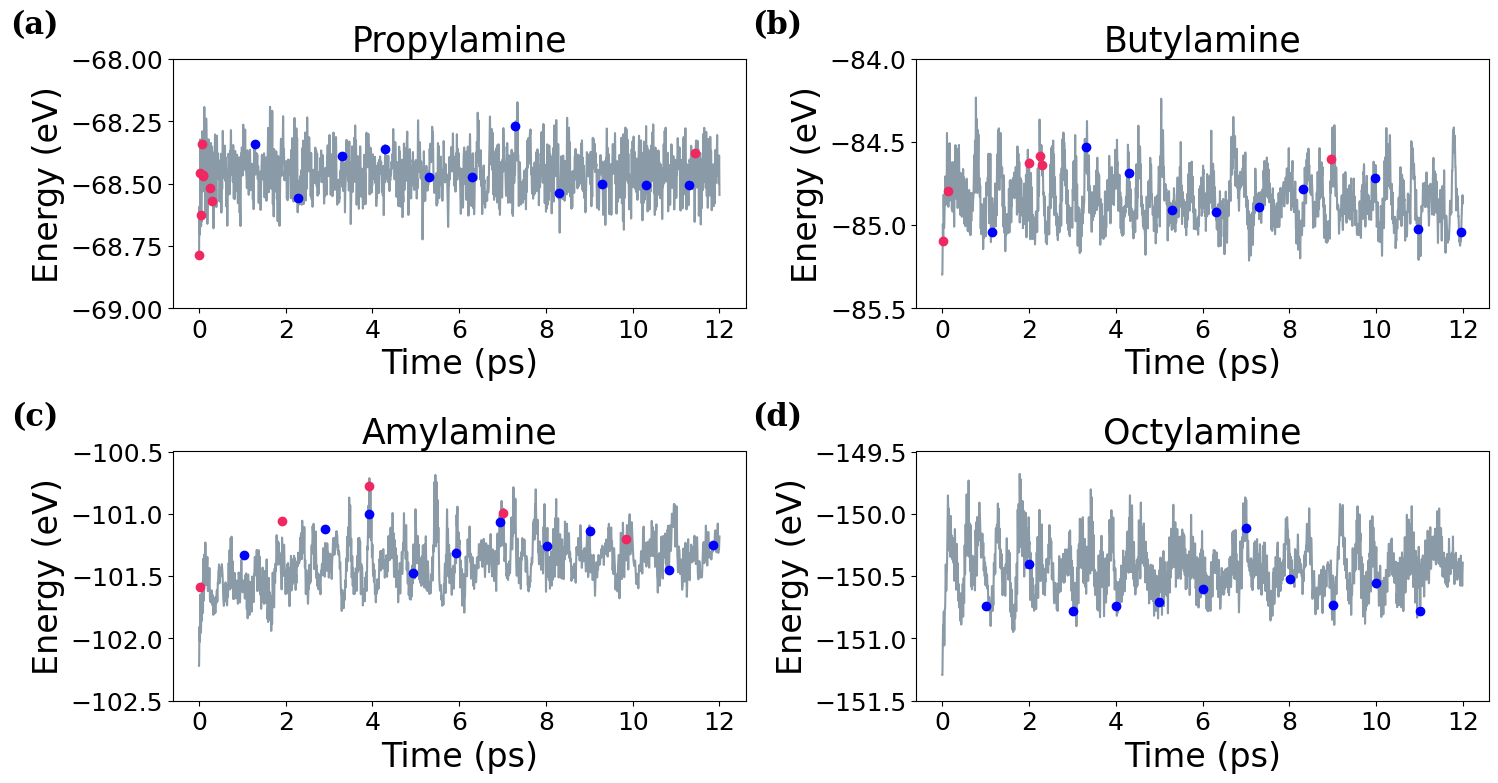

In [4]:
import matplotlib.pyplot as plt
import datetime

def timestamp(string=None, fmt="%m/%d/%Y %H:%M:%S"):
    if string is not None:
        d = datetime.datetime.strptime(string, fmt)
    else:
        d = datetime.datetime.now()
    return d.timestamp()

def parse_logfile(file="active.log", window=(None, None)):
    start = None
    settings = []
    elapsed = []
    energies = []
    temperatures = []
    covloss = []
    exact_energies = []
    test_energies = []

    meta = []
    for line in open(file):

        if line.startswith("#"):
            continue

        s = line.split()
        ts = timestamp(" ".join(s[:2]))
        if start is None:
            start = ts
        ts = (ts - start) / 60
        split = s[2:]

        if split[1] == "settings:":
            settings = {}
            b = None
            for a in split[2:]:
                if ":" in a:
                    settings[a] = ""
                    b = a
                else:
                    settings[b] += a
            settings = {a: eval(b) for a, b in settings.items()}

        try:
            step = int(split[0])
            if window[0] and step < window[0]:
                continue
            if window[1] and step > window[1]:
                break
        except IndexError:
            continue

        elapsed += [(step, ts)]

        try:
            energies += [(step, float(split[1]))]
            temperatures += [(step, float(split[2]))]
            covloss += [(step, float(split[3]))]
        except:
            pass

        if "meta:" in split:
            meta += [(step, float(split[split.index("meta:") + 1]))]

        if "exact energy" in line:
            exact_energies += [(step, float(split[3]))]

        if "testing energy" in line:
            test_energies += [(step, float(split[3]))]

    return (
        energies,
        exact_energies,
        test_energies,

    )

def log_to_figure(
    files, titles, figsize=(15, 8), window=(None, None), meta_ax=True, plot_test=True, xlim=None, ylims=None
):
    import matplotlib.pyplot as plt

    # 2x2 subplot 생성
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    # Flatten the 2x2 array of axes for easier iteration
    axs = axs.ravel()

    # 파일마다 subplot을 그리기
    for i, (file, title, ax) in enumerate(zip(files, titles, axs)):
        ml, fp, test = parse_logfile(file, window=window)

        # ML 데이터 플롯 - Convert fs to ps by dividing by 1000
        if len(ml) > 0:
            x, y = zip(*ml)
            # Convert x from fs to ps
            x_ps = [x_val/1000 for x_val in x]
            ax.plot(x_ps, y, color='#8A9BA7', zorder=1)
        
        # ab initio 데이터 플롯 - Convert fs to ps
        if len(fp) > 0:
            r, s = zip(*fp)
            # Convert r from fs to ps
            r_ps = [r_val/1000 for r_val in r]
            ax.scatter(r_ps, s, color="#F12761", zorder=2)
        
        # test 데이터 플롯 - Convert fs to ps
        if len(test) > 0:
            r, s = zip(*test)
            # Convert r from fs to ps
            r_ps = [r_val/1000 for r_val in r]
            ax.scatter(r_ps, s, color="b", zorder=2)
        
        ax.set_ylabel("Energy (eV)", fontsize=24)
        ax.set_xlabel("Time (ps)", fontsize=24)  # Changed label from fs to ps

        ax.tick_params(axis='both', which='major', labelsize=18)  # Smaller tick labels for both axes

        # X, Y axis limits for each subplot
        if xlim:
            # Convert xlim from fs to ps if provided
            ax.set_xlim([x/1000 for x in xlim] if xlim else xlim)
        
        # 각 subplot에 대한 개별 y 축 설정
        if ylims and ylims[i]:
            ax.set_ylim(ylims[i])
        
        # 범례 제거 (legend removed)
        # ax.legend(fontsize=9, loc='lower right')
        
        ax.set_title(title, fontsize=25)

        # Add letter (a), (b), (c), (d) to the subplot
        letter = chr(ord('a') + i)
        ax.text(-0.2, 1.2, f'({letter})', transform=ax.transAxes, 
                fontsize=22, fontweight='bold', va='top', ha='right', fontfamily='serif')

    # 레이아웃 조정
    plt.tight_layout()

    return fig

# Example of how to call the function with different files, custom titles, and individual y-axis limits
files = [
    '../Data/Fig.1/propylamine_0/active.log',
    '../Data/Fig.1/butylamine_0/active.log',
    '../Data/Fig.1/amylamine_0/active.log',
    '../Data/Fig.1/octylamine_0/active.log'
]

titles = [
    'Propylamine',
    'Butylamine',
    'Amylamine',
    'Octylamine'
]


# 각 subplot에 대한 y 축 범위 설정
ylims = [
    (-69, -68.0),       # Propylamine
    (-85.5, -84.0),     # Butylamine
    (-102.5, -100.5),   # Amylamine
    (-151.5, -149.5)    # Octylamine
]
fig = log_to_figure(files=files, titles=titles, ylims=ylims)


plt.savefig('figure1.png', dpi=600)